In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from matplotlib import colors as mcolors
import torch
import torch.nn as nn
import torch.optim as optim

import random
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision import datasets, models, transforms
from sklearn.decomposition import PCA, FastICA
import itertools
import yaml
from argparse import Namespace
import copy

%matplotlib inline

sys.path.append('../../src')
import tforms
import feature_extraction.feature_extraction_utils as futils
from feature_extraction.Network_Latents_Wrapper import NetworkLatents
import datasets_utils as dsetutils
import utils

sys.path.append('../../src/novelty_dfm_CL')

import novelty_dfm_CL.datasets_holdout_validation as dseth
import novelty_dfm_CL.novelty_detector as novel
import novelty_dfm_CL.novelty_eval as novelval 
import novelty_dfm_CL.classifier as clf
import novelty_dfm_CL.novelty_utils as novelu
import novelty_dfm_CL.incDFM_w_validation as novelinc
import novelty_dfm_CL.novelty_dataset_wrappers as dwrap


# Experiments 
# ------------------
# Have 0,1 --> 0,1
# Have 0,1 --> 2
# have 0,1 --> 2,3 

general_config_path = '/lab/arios/ProjIntel/incDFM/src/configs_new/incDFM_rebuttal.yaml'


with open(general_config_path) as fid:
    args = Namespace(**yaml.load(fid, Loader=yaml.SafeLoader))
    
args = utils.results_saving_setup(args)

# 1) ----- Dataset 
if not hasattr(args, 'experiment_filepath'):
    args.experiment_filepath = None # have dictionary for defaults???
if not hasattr(args, 'experiment_name'):
    args.experiment_name = None # have dictionary for defaults??

args = utils.save_ood_config_simple(args)



In [3]:

# load holdout dset
datasets_use = dseth.call_dataset_holdout_w_validation(args.dset_name, args.data_dir, args.experiment_dir, 
                                        experiment_filepath=args.experiment_filepath, experiment_name=args.experiment_name, 
                                        holdout_percent=args.holdout_percent,  val_holdout=args.val_percent, scenario=args.scenario, 
                                        num_per_task=args.num_per_task, num_classes_first=args.num_classes_first, 
                                        type_l_cifar=args.type_l_cifar, num_tasks_cifar=args.num_tasks_cifar, num_tasks=args.num_tasks, 
                                        shuffle=args.shuffle_order, preload=args.preload, keep_all_data=args.keep_all_data, \
                                            equalize_labels=args.equalize_labels, clip_labels=args.clip_labels, clip_max=args.clip_max)

if args.keep_all_data==True:
    train_datasets, train_holdout_datasets, train_datasets_new_only, val_datasets, test_datasets, list_tasks, list_tasks_targets, dset_prep = datasets_use
else:
    train_datasets, train_holdout_datasets, val_datasets, test_datasets, list_tasks, list_tasks_targets, dset_prep = datasets_use




args.dset_prep = dset_prep
old_dsets = train_holdout_datasets
old_dsets_test = test_datasets
use_old_dsets = copy.deepcopy(train_holdout_datasets)
use_old_dsets_test = copy.deepcopy(test_datasets)
 

num_tasks = len(train_datasets)


test_loaders = [torch.utils.data.DataLoader(test_datasets[t], batch_size=args.batchsize_test,
                                                shuffle=True, num_workers=args.num_workers) for t in range(num_tasks)]


num_old_per_task = {}
num_old_per_task_test = {}
ratio_per_task={}
for t_w in range(1,num_tasks):
    print('compute ratios data')
    # how much to mix from old and new in one task
    num_old, num_new, num_old_per_task_pt = novelu.num_mix_old_novelty(args.percent_old_mix, train_datasets[t_w], old_dsets[:t_w], t_w, list_tasks_targets[:t_w])
    print('Task', t_w, 'num_old', num_old,  'num_new', num_new, 'num_old_per_task', num_old_per_task_pt)
    num_old_per_task[t_w] = num_old_per_task_pt
    ratio_per_task[t_w] = num_new/(num_old+num_new)

for t_w in range(1,num_tasks):
    print('compute ratios data test')
    # how much to mix from old and new in one task
    num_old_test, num_new_test, num_old_per_task_pt_test = novelu.num_mix_old_novelty(args.percent_old_mix, test_datasets[t_w], old_dsets_test[:t_w], t_w, list_tasks_targets[:t_w])
    print('Task', t_w, 'num_old', num_old_test,  'num_new', num_new_test, 'num_old_per_task', num_old_per_task_pt_test)
    num_old_per_task_test[t_w] = num_old_per_task_pt_test




# 2) ------ Network 
if len(args.fc_sizes)>0:
    fc_sizes = args.fc_sizes.split(",")
    fc_sizes = [int(x) for x in fc_sizes]
else:
    fc_sizes = []
network = clf.Resnet(dset_prep['total_classes'], resnet_arch=args.net_type, FC_layers=fc_sizes, base_freeze=True)
network = network.to(args.device)
dfm_inputs = args.dfm_layers_input.split(",")
dfm_layers_factors = str(args.dfm_layers_factors)
dfm_layers_factors = dfm_layers_factors.split(',')
dfm_inputs_factors = {}
for n in range(len(dfm_inputs)):
    dfm_inputs_factors[dfm_inputs[n]]=int(dfm_layers_factors[n]) #adaptive pooling 
network_inner = NetworkLatents(network, dfm_inputs, pool_factors=dfm_inputs_factors)


args.patience_lr = int(np.ceil(args.schedule_patience_perepoch*args.num_epochs))


first_task [0, 1] 2 0
seq_tasks:  [[0, 1], [2, 3]] 1
*****Prep Data*****
Load existing Experiment ../../sandbox/Experiments_DFM_CL_Rebuttal/cifar10/rebuttal_intraclass_2_by_2/
../../sandbox/Experiments_DFM_CL_Rebuttal/cifar10/rebuttal_intraclass_2_by_2/
number tasks 2
prepared datasets 1.6544325351715088
compute ratios data
list_tasks [[0, 1]]
Task 1 num_old 2000 num_new 7000 num_old_per_task [2000]
compute ratios data test
list_tasks [[0, 1]]
Task 1 num_old 2000 num_new 2000 num_old_per_task [2000]
load contrastive backbone
Will fetch activations from:
base.8, average pooled by -1


In [4]:

# 3) ---- Novelty
args.detector_params['target_ind']=dset_prep['scenario_classif']
args.detector_params['device']=args.device
if args.novelty_detector_name=='odin':
    args.detector_params['base_network']=network #simple network (not wrapper) - Is this problematic? TODO
    args.detector_params['num_classes']=dset_prep['total_classes']
    args.detector_params['criterion']= nn.CrossEntropyLoss()
    args.detector_params['num_epochs']=args.num_epochs
    args.detector_params['train_technique']=args.train_technique
    args.detector_params['lr']=args.lr
    args.detector_params['patience_lr'] = args.patience_lr
    args.detector_params['schedule_decay'] = args.schedule_decay
    args.detector_params['step_size_epoch_lr']= args.step_size_epoch_lr
    args.detector_params['gamma_step_lr']= args.gamma_step_lr
elif args.novelty_detector_name=='softmax':
    args.detector_params['base_network']=network #simple network (not wrapper) - Is this problematic? TODO
    args.detector_params['num_classes']=dset_prep['total_classes']


noveltyResults = novelval.save_novelty_results(num_tasks, args.experiment_name_plot, args.dir_save)
novelty_detector = novel.NoveltyDetector().create_detector(type=args.novelty_detector_name, params=args.detector_params)


def get_features(dataset, network_inner, device=0):

    loader = torch.utils.data.DataLoader(dataset, batch_size=100,
                                            shuffle=True, num_workers=4)
    start = time.time()
    print('feat extraction begin')
    current_features = futils.extract_features(network_inner, loader, \
            target_ind=1, homog_ind=-2, device=device)

    print('feat extraction done', time.time()-start)
    feat_name = 'base.8'

    X = current_features[0][feat_name]
    Y = current_features[-2]

    return X, Y, current_features



In [5]:

train_dataset_ID = train_datasets[0]

# Training - Only ID -------------
Feats_ID_train = get_features(train_dataset_ID, network_inner, device=args.device)
novelty_detector.fit_total(Feats_ID_train[0].T, Feats_ID_train[1])

feat extraction begin


100%|██████████| 70/70 [00:12<00:00,  5.50it/s]


feat extraction done 12.738277673721313


In [6]:

params_score = {'layer':'base.8', 'feature_extractor':network_inner, 'base_apply_score':True, 'target_ind':1}


Feats_OOD = copy.deepcopy(train_datasets[1])
Feats_ID = use_old_dsets[0]

# mix old (holdout) with new data for "current task"    
print('Get scores for novelty detector')
Feats_ID.select_random_subset(2000)
Feats_OOD.select_random_subset(2000)

    
current_dset = dwrap.CurrentTask(Feats_OOD, [Feats_ID])
current_loader = torch.utils.data.DataLoader(current_dset, batch_size=100,
                                                shuffle=False, num_workers=4)


results_novelty = novelval.evaluate_simple_CL(1, novelty_detector, noveltyResults, params_score, current_loader, 'dfm')

Get scores for novelty detector
New task 1, AUROC = 0.967, AUPR = 0.969, AUPR_NORM = 0.969
new_scores [0.13367787 0.71241748 0.72588694 ... 1.02474356 0.7749697  1.08543396]
old_scores [0.43052685 0.36192754 0.36078835 ... 0.27912539 0.19655183 0.33491546]
Results -  Auroc 0.967, Aupr 0.969, Aupr_norm 0.969
Average Accuracy per class old 0.9830


In [7]:
results_novelty.scores, results_novelty.gt_novelty

(array([0.13367787, 0.71241748, 0.72588694, ..., 0.27912539, 0.19655183,
        0.33491546]),
 array([1, 1, 1, ..., 0, 0, 0]))

New task 1, AUROC = 0.965, AUPR = 0.982, AUPR_NORM = 0.982
new_scores [0.13367787 0.71241748 0.72588694 ... 1.02474356 0.7749697  1.08543396]
old_scores [0.27232325 0.29494274 0.21153177 0.49308366 0.37964153 0.28939575
 0.16133583 0.15648128 0.32777816 0.21923673 0.33835873 0.21278693
 0.20607366 0.17653257 0.2007238  0.30578357 0.18489486 0.21057747
 0.46187901 0.35325092 0.19708864 0.23971613 0.17921147 0.2794528
 0.53518111 0.16822752 0.36836335 0.18366081 0.34999722 0.36467484
 0.3061735  0.14733966 0.52665013 0.34493455 0.24294928 0.20398632
 0.231731   0.29768968 0.22184727 0.19808629 0.16924614 0.39459383
 0.35972804 0.29962945 0.24166095 0.27177018 0.37461001 0.14683081
 0.35643744 0.48995867 0.42252883 0.10018012 0.2931096  0.69382548
 0.39367849 0.50379694 0.18628095 0.1889604  0.22313346 0.33878434
 0.35186404 0.12607518 0.34470055 0.32288706 0.2956982  0.30098796
 0.39803654 0.23492381 0.26495957 0.20477886 0.27175194 0.31061718
 0.43435425 0.30080187 0.26213717 0.16888213

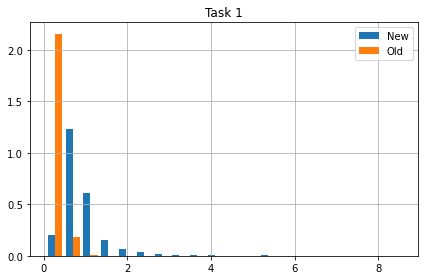

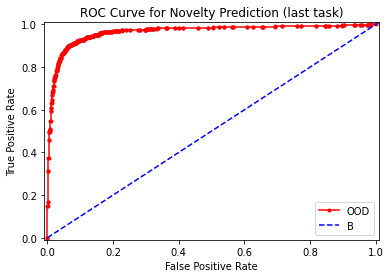

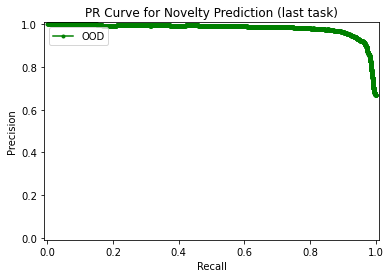

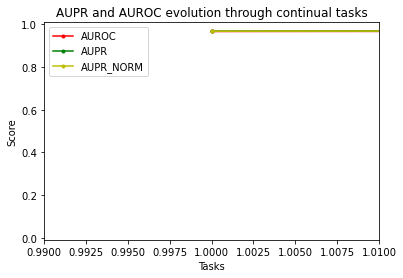

In [15]:


# class CurrentTask_OnlyOld():
#     def __init__(self, old_dsets, use_coarse=False, returnIDX=False):
#         """ 
#         combine old IID task samples and New task samples
#         Load x_old and y_old data here (already subsampled if applicable)
#             --> Consider bypassing dsetTask and loading the experiment_indices directly here
#         x = torch
#         y = numpy
#         novelty_y = numpy
#         """
#         self.use_coarse = use_coarse
        
#         self.dsets = old_dsets
                
#         indices_task_old = []
#         for j, dset in enumerate(old_dsets):
#             indices_task_old.extend(list(zip([j+1 for i in range(dset.__len__())], [i for i in range(dset.__len__())])))
#         self.novelty_y = np.zeros(len(indices_task_old))
            
        
#         self.indices_task = copy.deepcopy(indices_task_old)
                    
#         self.returnIDX = returnIDX
        

#     def __len__(self):
#         return len(self.indices_task)
    
        
#     def __getitem__(self, idx):
        
#         dset_id, idx_dset = self.indices_task[idx]
        
#         # print('dset_id', dset_id)
        
#         im, y_fine, y_coarse = self.dsets[dset_id].__getitem__(idx_dset)
        
#         if self.use_coarse:
#             class_lbl = y_coarse
#         else:
#             class_lbl = y_fine

#         novelty_lbl = self.novelty_y[idx]

#         if self.returnIDX:
#             return im, class_lbl, novelty_lbl, idx
            
#         return im, class_lbl, novelty_lbl



# train_dataset_ID

old_old_val_ID = val_datasets[0]

old_old_val_ID.select_random_subset(2000)
    
current_dset_train = dwrap.CurrentTask(Feats_OOD, [old_old_val_ID])
current_loader_train = torch.utils.data.DataLoader(current_dset_train, batch_size=100,
                                                shuffle=False, num_workers=4)



results_novelty_train = novelval.evaluate_simple_CL(1, novelty_detector, noveltyResults, params_score, current_loader_train, 'dfm')

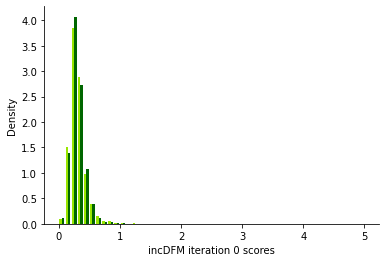

In [71]:

old_old_scores = results_novelty_train.scores[results_novelty_train.gt_novelty==0]

new_scores = results_novelty.scores[results_novelty.gt_novelty==1]
old_scores = results_novelty.scores[results_novelty.gt_novelty==0]



# ['#99e600', '#006600']

ax = plt.subplot(111)

ax.hist([old_old_scores, old_scores], bins=50, density=True, range=[0,5], align='mid', color=['#99e600', '#006600'])
ax.set_xlabel('incDFM iteration 0 scores')
ax.set_ylabel('Density')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [53]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc


# old_old_scores


scores = np.concatenate((old_old_scores, old_scores))
ground_truth_novelty = np.concatenate((np.zeros(old_old_scores.shape), np.ones(old_scores.shape)))

fpr, tpr, _ = roc_curve(ground_truth_novelty, scores)
# prec, recall, _ = precision_recall_curve(ground_truth_novelty, scores)
auroc = auc(fpr, tpr)
print(auroc)

0.5019939999999999


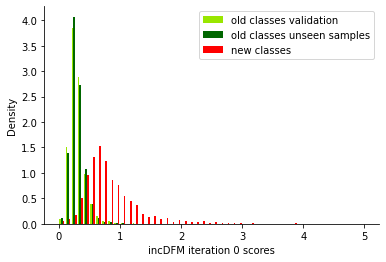

In [76]:

old_old_scores = results_novelty_train.scores[results_novelty_train.gt_novelty==0]

new_scores = results_novelty.scores[results_novelty.gt_novelty==1]-0.08
old_scores = results_novelty.scores[results_novelty.gt_novelty==0]


ax = plt.subplot(111)

ax.hist([old_old_scores, old_scores, new_scores], bins=50, density=True, range=[0,5], align='mid', color=['#99e600', '#006600', 'r'], label=['old classes validation', 'old classes unseen samples', 'new classes'])
ax.set_xlabel('incDFM iteration 0 scores')
ax.set_ylabel('Density')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

In [64]:
scores = np.concatenate((old_scores, new_scores))
ground_truth_novelty = np.concatenate((np.zeros(old_scores.shape), np.ones(new_scores.shape)))

fpr, tpr, _ = roc_curve(ground_truth_novelty, scores)
# prec, recall, _ = precision_recall_curve(ground_truth_novelty, scores)
auroc = auc(fpr, tpr)
print(auroc)

0.94227525


In [74]:

scores_incdfm = np.load('/lab/arios/ProjIntel/incDFM/sandbox/test_scores_rebuttal_2_2_incdfm.npy')


scores_incdfm_seen = np.load('/lab/arios/ProjIntel/incDFM/sandbox/seen_scores_rebuttal_2_2_incdfm.npy')

new_scores_incdfm = scores_incdfm[0,scores_incdfm[1,...]==1]

old_scores_incdfm = scores_incdfm[0,scores_incdfm[1,...]==0]

old_old_scores_incdfm = scores_incdfm_seen[0,scores_incdfm_seen[1,...]==0]


# new_scores_incdfm.mean(), old_scores_incdfm.mean()

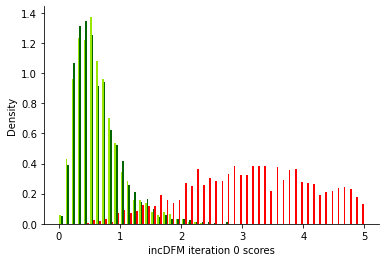

In [75]:

ax = plt.subplot(111)

ax.hist([old_old_scores_incdfm, old_scores_incdfm, new_scores_incdfm], bins=50, density=True, range=[0,5], align='mid', color=['#99e600', '#006600', 'r'])
ax.set_xlabel('incDFM iteration 0 scores')
ax.set_ylabel('Density')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [55]:
scores = np.concatenate((old_scores_incdfm, new_scores_incdfm))
ground_truth_novelty = np.concatenate((np.zeros(old_scores_incdfm.shape), np.ones(new_scores_incdfm.shape)))

fpr, tpr, _ = roc_curve(ground_truth_novelty, scores)
# prec, recall, _ = precision_recall_curve(ground_truth_novelty, scores)
auroc = auc(fpr, tpr)
print(auroc)

0.991078


In [12]:
old_scores

array([0.32900172, 0.3405436 , 0.22744976, ..., 0.44704172, 0.30023366,
       0.3182396 ])